# This code is a prediction for CD
## Test early stopping & late stopping
    - early stopping: 50 epoches
    - late atopping:  200 epoches
## Ensemble average of 30 times
- bessel filter; $w_n = 0.01$, the frequence based on Nyquist rate (=sample_freq/2) is: $0.01*1000/2=5$
- no standardization; no normalization
- with L2
- activation func: PReLU
- No CP'(t), CP''(t) !!!


# Define which task to run:
##  task  = ['predict', 'cross_validation']
### 'cross_validation': for cross validation; has 7 folds
### 'predict': for test using parameters chose by cross validation; has 1 fold --> fold8
##  force = ['CL', 'CD']
##  filt  = ['bessel', 'no filter']

In [1]:
task = 'predict' 
force = 'CD'     
filt = 'bessel' 
ensemble_num = 30

if task == 'cross_validation':
    folds = 7
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

Define the task complete.


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics, regularizers
from tensorflow.keras.layers import Activation, Dense, Input

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 使用第二，三块GPU "2,3"（从0开始）


In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import datetime
import time
import pandas as pd
from scipy.signal import bessel
from scipy.signal import filtfilt


In [5]:
# initialize the data
history_all = {}
predictions = {}

# folder path
data_path = 'D:/myProject/Exam/Thesis/dashuai/deltaWing/organized_data_from_Frieder/data_force_on_earth_Coordinate_System/' + '2023-01-11-filter-no/gust_dataframe.xlsx'

# read the excel data
gust_origin = pd.read_excel(data_path)

In [6]:
gust_origin.head()

,case_number,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
0,case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
1,case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
2,case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
3,case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
4,case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [7]:
# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

(80000, 18)


,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [8]:
# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j])  # bessel for CP
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

In [9]:
# check gust
gust.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-0.989251,-0.586589,-0.749452,-0.958598,-0.410507,-0.453256,-0.557566,-0.739864,-0.991654,-0.240513,-0.273198,-0.319951,-0.390352,-0.577261,-1.208769,0.910732,0.533331,0.125085
case_01,-0.988749,-0.586124,-0.749185,-0.958168,-0.410153,-0.452932,-0.557203,-0.739344,-0.991436,-0.240332,-0.273074,-0.319834,-0.390250,-0.576948,-1.208118,0.911979,0.520047,0.117766
case_01,-0.988245,-0.585658,-0.748917,-0.957735,-0.409799,-0.452607,-0.556838,-0.738825,-0.991217,-0.240149,-0.272949,-0.319716,-0.390147,-0.576633,-1.207466,0.913226,0.527826,0.136049
case_01,-0.987740,-0.585190,-0.748647,-0.957301,-0.409444,-0.452283,-0.556473,-0.738306,-0.990998,-0.239966,-0.272824,-0.319598,-0.390045,-0.576318,-1.206813,0.914474,0.546522,0.142592
case_01,-0.987234,-0.584721,-0.748377,-0.956865,-0.409090,-0.451958,-0.556105,-0.737788,-0.990778,-0.239781,-0.272698,-0.319480,-0.389941,-0.576002,-1.206159,0.915721,0.518274,0.123129


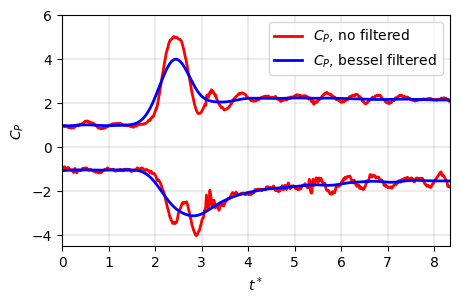

In [11]:
# check filter result

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = np.arange(0,10000) / f / T 

if filt == 'bessel':
    ii = 13 # case to show
    case_to_show = 'case_' + str(ii).zfill(2)
    cp_to_show   = [-3,-4] # -3 is p0 (stagnation point), -4 is p16(training edge point)
    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, no filtered', color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, bessel filtered', color='b', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='b', linewidth=2)
    ax.legend()
    ax.margins(x=0)
    ax.set_xlabel('$t^*$')
    ax.set_ylabel('$C_{P}$')
    ax.set_ylim(-4.5,6)
    ax.grid(color='k', linestyle='-', linewidth=0.1)
    
elif filt == 'no filter':
    print('No filter. No compare.')
else:
    print('Error. Please define your filter.')

# fig.savefig('CP_Filter_case_%d_port%d.png' % (ii,0), bbox_inches='tight', dpi=300)
# fig.savefig('CP_Filter_case_%d_port%d.svg' % (ii,0), bbox_inches='tight')

In [12]:
# retrieve CP, 16(CP) + 16(CP_1st_order) + 16(CP_2nd_order) = 48 columns in total
# simply drop CL and CD, then the rest is CP
CP = gust.drop(['CL','CD'],axis=1, inplace=False)
CP.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t
case_number,,,,,,,,,,,,,,,,
case_01,-0.989251,-0.586589,-0.749452,-0.958598,-0.410507,-0.453256,-0.557566,-0.739864,-0.991654,-0.240513,-0.273198,-0.319951,-0.390352,-0.577261,-1.208769,0.910732
case_01,-0.988749,-0.586124,-0.749185,-0.958168,-0.410153,-0.452932,-0.557203,-0.739344,-0.991436,-0.240332,-0.273074,-0.319834,-0.390250,-0.576948,-1.208118,0.911979
case_01,-0.988245,-0.585658,-0.748917,-0.957735,-0.409799,-0.452607,-0.556838,-0.738825,-0.991217,-0.240149,-0.272949,-0.319716,-0.390147,-0.576633,-1.207466,0.913226
case_01,-0.987740,-0.585190,-0.748647,-0.957301,-0.409444,-0.452283,-0.556473,-0.738306,-0.990998,-0.239966,-0.272824,-0.319598,-0.390045,-0.576318,-1.206813,0.914474
case_01,-0.987234,-0.584721,-0.748377,-0.956865,-0.409090,-0.451958,-0.556105,-0.737788,-0.990778,-0.239781,-0.272698,-0.319480,-0.389941,-0.576002,-1.206159,0.915721


In [13]:
# retrieve CL and CD
CL = gust[['CL']]
CD = gust[['CD']]
gust[[force]].head()

,CD
case_number,
case_01,0.125085
case_01,0.117766
case_01,0.136049
case_01,0.142592
case_01,0.123129


In [15]:
# retrieve for 8 different folds
# read the split .txt file; the number means the cases for test
split_path = 'D:/myProject/Exam/Thesis/dashuai/deltaWing/organized_data_from_Frieder/data_force_on_earth_Coordinate_System/' + 'delta_wing_32cases_split_random.txt'
with open(split_path, 'r') as file1:    
    fold_split = file1.read().splitlines()       # split by \n
fold_split = fold_split[1:] # drop the head line
for i in range(8):
    fold_split[i] = fold_split[i][9:].split()    # split by space; the number starts from 10th character.
    for j in range(4):
        fold_split[i][j] = int(fold_split[i][j]) # convert string to int
fold_split

[[4, 19, 26, 30],
 [5, 14, 31, 32],
 [1, 18, 22, 29],
 [6, 10, 16, 17],
 [2, 8, 11, 24],
 [3, 7, 15, 27],
 [9, 12, 21, 23],
 [13, 20, 25, 28]]

In [16]:
# define the 32 case number
case_all_num = np.arange(gust.index.nunique()) + 1
print(case_all_num)
print(case_all_num.shape)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
(32,)


In [17]:
# find the case number for train and test cases;
if task == 'cross_validation':
    train_case = [ [0]*24 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for cross validation folds: fold1~fold7
    for i in range(folds): 
        train_case_temp = np.setdiff1d( case_all_num, np.concatenate((fold_split[i], fold_split[-1]))) 
        # drop test case and the last one (which is for fold 8 , final test)
        test_case_temp  = fold_split[i]

        # conbine to 'case_nn' sample for train and test case; prepare for next step
        for j in range(len(train_case_temp)):
            train_case[i][j] = 'case_' + str(train_case_temp[j]).zfill(2)
        for k in range(len(test_case_temp)):
            test_case[i][k]  = 'case_' + str(test_case_temp[k]).zfill(2)
            
elif task == 'predict': 
    train_case = [ [0]*28 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for test fold: fold8  
    train_case_temp = np.setdiff1d(case_all_num, fold_split[-1])
    test_case_temp  = fold_split[-1]
    for jj in range(len(train_case_temp)):
        train_case[-1][jj] = 'case_' + str(train_case_temp[jj]).zfill(2)
    for kk in range(len(test_case_temp)):
        test_case[-1][kk]  = 'case_' + str(test_case_temp[kk]).zfill(2)

else:
    print('Error. Please define your task.')

print(test_case[0])
print('Done!')

['case_13', 'case_20', 'case_25', 'case_28']
Done!


In [18]:
#  prepare for train and test data sets
if task == 'cross_validation':
    F_train_rec = np.zeros([folds,60000,1]) # 24*2500 = 60000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,60000,48])
    P_test_rec  = np.zeros([folds,10000,48])

    for i in range(folds): # 7 folds for training, the last one is for test, not retrieve here, since this is for training
        if force == 'CL':
            F_train_rec[i] = CL.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CL.loc[test_case[i]].to_numpy()
        elif force == 'CD':
            F_train_rec[i] = CD.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CD.loc[test_case[i]].to_numpy()
        else:
            print('Error. Please define force.')

        P_train_rec[i] = CP.loc[train_case[i]].to_numpy()
        P_test_rec[i]  = CP.loc[test_case[i]].to_numpy()

elif task == 'predict':
    F_train_rec = np.zeros([folds,70000,1]) # 28*2500 = 70000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,70000,16])
    P_test_rec  = np.zeros([folds,10000,16])
    
    if force == 'CL':
        F_train_rec[0] = CL.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CL.loc[test_case[0]].to_numpy()
    elif force == 'CD':
        F_train_rec[0] = CD.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CD.loc[test_case[0]].to_numpy()
    else:
        print('Error. Please define force.')

    P_train_rec[0] = CP.loc[train_case[0]].to_numpy()
    P_test_rec[0]  = CP.loc[test_case[0]].to_numpy()
    
else:
    print('Error. Please define your task.')
    
print('Done')

Done


In [19]:
print(task)
print(force)
print(folds)
print(filt)

predict
CD
1
bessel


In [20]:
''' begin training '''

from keras.models import load_model
from keras.layers import LeakyReLU, PReLU 

num_neuron = [72]#[16, 24, 32, 40, 48, 56, 64, 72]
num_layer  = [8]#[1,2,3,4,5,6,7,8]
epoch_total = 200 # 200 #l1_n8:193; l1_n16:196; l1_n24:189; l1_n32:166
weight_decay = 0 # 5e-4 # l2 regularization hyperparameter
learn_rate   = 1e-5 # 1e-4
batch_how    = 200  # 200

ensemble_num = 30

# define callback: predict on each epoch
class prediction_for_each_epoch(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_predictions = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_predictions.append(model.predict(P_test))
        
# record start time
starttime = datetime.datetime.now()
# sleep 2 seconds
time.sleep(0)

for i in num_neuron: # define the neurons
    
    for j in num_layer: # define the hidden layers
        
        for k in range(ensemble_num): # start loop; if folds=7, then do cross validation; if folds=1, then, do predict
            
            print('start fold'+str(k+1).zfill(2)+' | layer'+str(j)+' |neuron'+str(i))
            
            predictions[k,i,j]=prediction_for_each_epoch()
            
            F_train = F_train_rec[0][:,:]   # change to 2d for training
            F_test  = F_test_rec[0][:,:]
            P_train = P_train_rec[0][:,:]
            P_test  = P_test_rec[0][:,:]
            '''load data done'''
            
            model = Sequential()

            neuron = i

            # ##### build the model #####
            
            # Input layer, no activation for input layer, no L2
            model.add(Input(shape=(16,)))  
            
            # Hidden layer
            for jj in range(j):       
                model.add(Dense(neuron, kernel_regularizer=regularizers.l2(weight_decay))) 
                model.add(PReLU())
            
            # Output layer => output dimension = 1 since it is regression problem
            model.add(Dense(1, activation = 'linear', kernel_regularizer=regularizers.l2(weight_decay)))   
            
            model.summary()
            
            adam = optimizers.Adam(learning_rate = learn_rate)    
            
            model.compile(optimizer = adam, loss = 'mean_squared_error')#, metrics = ['mean_absolute_error'])    
            # for regression problems, mean squared error (MSE) is often employed; 
            # do not use 'accuracy', as this is used for classification problem
            
            # # load model, only for continuing training
            # model = load_model('neuron_' + str(num_neuron[0]) + '_layer_' + str(num_layer[0]) + '.h5')
            
            '''history_all[i,j] = '''
            model.fit(P_train, F_train, batch_size = batch_how, epochs = epoch_total, verbose = 2, shuffle=False, 
                                         validation_split=0.0, callbacks=[predictions[k,i,j]]) 
            # no shuffle for time-based data; no validation, since 7-fold cross-validation already include validaiton; 
            # callbacks is used for prediction history record; 
            # no need for history_all, which records the training error history, but we only care about predict error.

# record end time
endtime = datetime.datetime.now()
# print total time
print('code runs %d s' % (endtime - starttime).seconds)

start fold01 | layer8 |neuron72
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 72)                1224      
                                                                 
 p_re_lu (PReLU)             (None, 72)                72        
                                                                 
 dense_1 (Dense)             (None, 72)                5256      
                                                                 
 p_re_lu_1 (PReLU)           (None, 72)                72        
                                                                 
 dense_2 (Dense)             (None, 72)                5256      
                                                                 
 p_re_lu_2 (PReLU)           (None, 72)                72        
                                                                 
 dense_3 (Dense)        

In [21]:
ensemble_num

30

The index of the min value is: 199 | The min value is: 0.009136
The index of the min value is: 199 | The min value is: 0.007403
The index of the min value is: 199 | The min value is: 0.006445
The index of the min value is: 199 | The min value is: 0.006038
The index of the min value is: 199 | The min value is: 0.008217
The index of the min value is: 199 | The min value is: 0.012229
The index of the min value is: 199 | The min value is: 0.008556
The index of the min value is: 199 | The min value is: 0.012135
The index of the min value is: 199 | The min value is: 0.007503
The index of the min value is: 199 | The min value is: 0.005666
The index of the min value is: 192 | The min value is: 0.005139
The index of the min value is: 199 | The min value is: 0.005130
The index of the min value is: 199 | The min value is: 0.004194
The index of the min value is: 199 | The min value is: 0.011308
The index of the min value is: 199 | The min value is: 0.012092
The index of the min value is: 199 | The

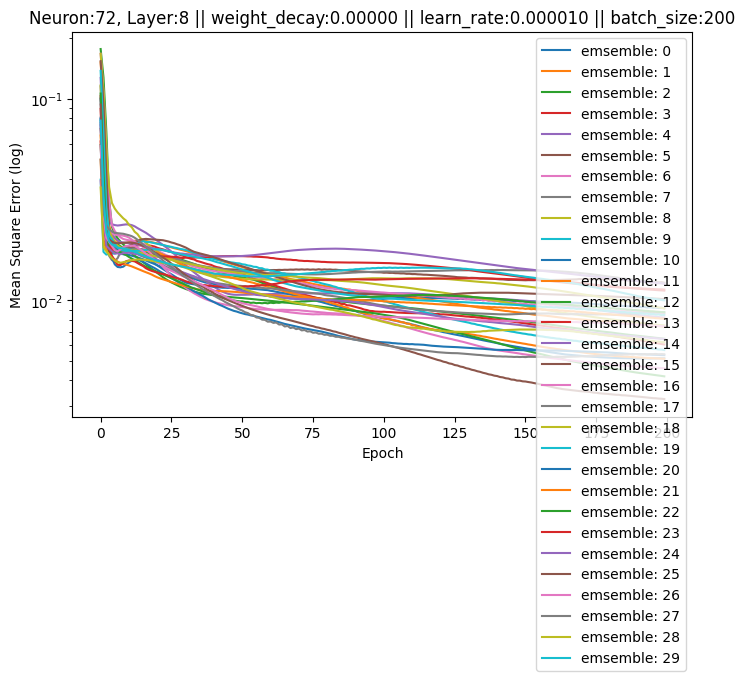

In [22]:
# plot the mse history   
from sklearn.metrics import mean_squared_error as mse
mse_pred_per_epoch = np.zeros([ensemble_num,epoch_total])

fig, axes = plt.subplots(1, 1, figsize=(8, 5))


neuron_this = num_neuron[0]
layer_this  = num_layer[0]

for i in range(ensemble_num): # number of folds
    for j in range(epoch_total):
        mse_pred_per_epoch[i,j] = mse(F_test_rec[0][:][:], predictions[i,neuron_this,layer_this].epoch_predictions[j][:,0])
    axes.semilogy(mse_pred_per_epoch[i,:], label='emsemble: %d' % (i))
    axes.legend()
    
    # find the index of the min value in an array
    aaa = mse_pred_per_epoch[i].tolist()
    min_value = min(aaa)
    min_value_index = aaa.index(min_value)
    print('The index of the min value is: %d | The min value is: %f' % (min_value_index, min_value))
# axes[0].set_xlim([0,50])
axes.set_xlabel('Epoch')
axes.set_ylabel('Mean Square Error (log)')
axes.set_title('Neuron:%d, Layer:%d || weight_decay:%.5f || learn_rate:%f || batch_size:%d' % (neuron_this,layer_this, weight_decay, learn_rate,batch_how))
# axes.text(165, 0.1, 'elu')

# axes.semilogy(history_all[num_neuron[0],num_layer[0]].history['loss'], label='train error')
axes.legend()

In [23]:
# this function finds the ensemble average of the epoch predictions and the std  history
# it returns the average result (array) and the std (array)
def ensemble_average(epoch_pred):
    sum_temp = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    sum_temp[:,0] = epoch_pred[:,0]
    std_hist = np.zeros((len(epoch_pred[0,:])))
    std_hist[0] = np.std(sum_temp[:,0])
    ensemble_averg = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    ensemble_averg[:,0] = epoch_pred[:,0]
    for i in range(len(epoch_pred[0,:])-1):
        sum_temp[:,i+1] = sum_temp[:,i] + epoch_pred[:,i+1]
        std_hist[i+1] = np.std(sum_temp[:,i+1]/(i+2))
        ensemble_averg[:,i+1] = sum_temp[:,i+1]/(i+2)
    return(std_hist, ensemble_averg)

In [24]:
# test function ensemble_average
a = np.array([[1,1,2,2],[1,2,1,3],[1,1,1,5]])
(b,c) = ensemble_average(a)
print(c)
print(b == np.std(np.array([[1,2/2,4/3,6/4],[1,3/2,4/3,7/4],[1,2/2,3/3,8/4]]),axis=0))

[[1.         1.         1.33333333 1.5       ]
 [1.         1.5        1.33333333 1.75      ]
 [1.         1.         1.         2.        ]]
[ True  True  True  True]


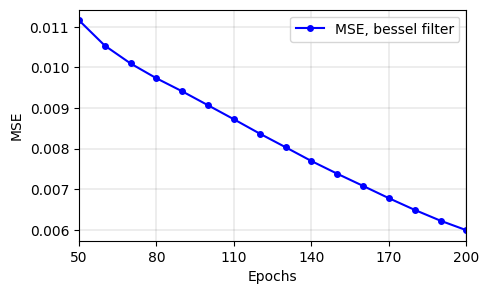

In [37]:
# this cell calcalute the mse of different ensembling average: 50,60,70,80,90,...200

ensemble_use = np.arange(50,210,10)
mse_ensemble_use  = {} # dictionary, with keys and values
epoch_hist_use    = np.zeros([len(ensemble_use),len(F_test_rec[0]),ensemble_num]) # 16*10000*30: 16 to show the mse, 10000 samples, 30 repeats
ensemble_avrg_use = {}
ensemble_std_use  = {}
ensemble_avrg_use = {}

fig,ax_use = plt.subplots(figsize=(5,3))
for j in ensemble_use: # [50,60,70,80,90,...200]
    for i in range(ensemble_num): # repeat ensemble_num times with same hyperparameters
        epoch_hist_use[int(j/10-5),:,i] = predictions[i,neuron_this,layer_this].epoch_predictions[j-1][:,0]
        
    (ensemble_std_use[j], ensemble_avrg_use[j]) = ensemble_average(epoch_hist_use[int(j/10-5)])
    
    mse_ensemble_use[j] = mse(ensemble_avrg_use[j][:,-1], F_test_rec[0][:,:])

ax_use.plot(mse_ensemble_use.keys(),mse_ensemble_use.values(),color='blue', linewidth=1.5,marker='.',markersize=8)
ax_use.set_xlim(50,200)
ax_use.set_xticks(np.arange(50,210,30).tolist())
# ax_use.set_ylim(0.010,0.026)
ax_use.grid(color='k', linestyle='-', linewidth=0.1)
ax_use.set_xlabel('Epochs')
ax_use.set_ylabel('MSE')
ax_use.legend(['MSE, bessel filter'])
fig.savefig('ensemble_error_Filter_neuron%d_layer%d_CD.png' % (neuron_this,layer_this), bbox_inches='tight', dpi=350)
fig.savefig('ensemble_error_Filter_neuron%d_layer%d_CD.svg' % (neuron_this,layer_this), bbox_inches='tight')

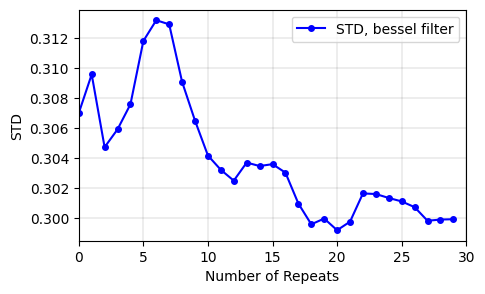

In [38]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(ensemble_std_use[200],color='blue', linewidth=1.5,marker='.',markersize=8)
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_xlabel('Number of Repeats')
ax.set_ylabel('STD')
ax.margins(x=0)
ax.set_xlim(0,30)
ax.legend(['STD, bessel filter'])
fig.savefig('STD_repeat_Filter_neuron%d_layer%d_CD.png' % (neuron_this,layer_this), bbox_inches='tight', dpi=350)
fig.savefig('STD_repeat_Filter_neuron%d_layer%d_CD.svg' % (neuron_this,layer_this), bbox_inches='tight')

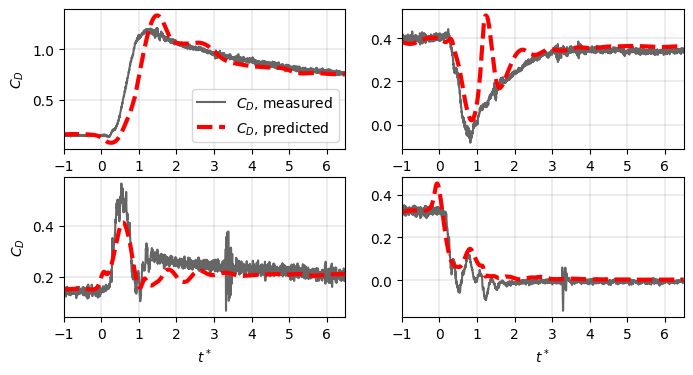

In [42]:
import matplotlib.patches as patches
fig, ax_split = plt.subplots(2,2,figsize=(8,4))
repeat_num = 200 # repeated number: 50 100

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000) - 500) / f / T 

fig_num = 0 # for count opnly
for i in range(4):
    if fig_num in [0,1]:
        p = 0
        q = fig_num
    else:
        p = 1
        q = fig_num - 2
    ax_split[p,q].plot(t_star[0:2500-1], F_test_rec[0][2500*i:2500*(i+1)-1,:],label='F_test',color='#666666', linewidth=1.5)
    ax_split[p,q].plot(t_star[0:2500-1], ensemble_avrg_use[repeat_num][2500*i:2500*(i+1)-1,-1],label='pred_average', 
                       color='red', linewidth=3, linestyle='--') # 50 and 200 epochs
    ax_split[p,q].grid(color='k', linestyle='-', linewidth=0.1)
    ax_split[p,q].set_xticks(np.arange(-1,8))
    ax_split[p,q].set_xlim(-1,6.5)
    ax_split[p,q].margins(x=0)
    ax_split[p,q].set_xlabel('$t^*$')
    fig_num = fig_num + 1
ax_split[0,0].set_ylabel('$C_{D}$')
ax_split[0,0].legend(['$C_{D}$, measured','$C_{D}$, predicted'])
ax_split[1,0].set_ylabel('$C_{D}$')

fig.savefig('ensemble%d_pred_Filter_neuron%d_layer%d_CD.png' % (repeat_num,neuron_this,layer_this), bbox_inches='tight', dpi=350)
fig.savefig('ensemble%d_pred_Filter_neuron%d_layer%d_CD.svg' % (repeat_num,neuron_this,layer_this), bbox_inches='tight')

In [ ]:
from keras.models import load_model
num_neuron = [72]#[16, 24, 32, 40, 48, 56, 64, 72]
num_layer  = [6]#[1,2,3,4,5,6,7,8]
model = load_model('neuron_' + str(num_neuron[0]) + '_layer_' + str(num_layer[0]) + 'case20_best' '.h5')
# check, plot
from sklearn.metrics import mean_squared_error as mse
T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = np.arange(0,10000) / f / T 
fig, axes = plt.subplots(1,1,figsize=(12, 5))

neuron_this = num_neuron[0]

layer_this  = num_layer[0]

# axes.set_ylim([-0.15,0.35])
# axes.set_ylim([9.8,10.4])
axes.plot(t_star, F_test_rec[0][:,:],label='F_test',color='red', linewidth=3)
axes.plot(t_star, model.predict(P_test_rec[0][:,:]), label='F_pred',color='blue', linewidth=2, linestyle='--')
axes.legend()
axes.set_xlabel('T$^*$')
axes.set_ylabel('CD')
axes.set_title('Fold08 Neuron: %d, Layer:%d || Mean_error:%.5f' % (neuron_this,layer_this, mse(F_test_rec[0][:,:],model.predict(P_test_rec[0][:,:]))))

In [ ]:
# save data as csv: cl without filter; cl with bessel filter
CP_filter   = gust.drop(['CL','CD'],axis=1, inplace=False)
CP_nofilter = gust_origin.drop(['CL','CD'],axis=1, inplace=False)

# CL_true_CL_no_filter = F_test_rec[0][:,:]
# CL_predit_CP_filter_bessel = model.predict(P_test_rec[0][:,:])

# t_star = pd.DataFrame(data=t_star).to_numpy() # convert t_start form 1d to 2d
# predict_CL_no_filter_CP_filter_bessel = np.concatenate((t_star, CL_true_CL_no_filter, CL_predit_CP_filter_bessel), axis=1)

# predict_CP_filter_bessel = pd.DataFrame(data=predict_CL_no_filter_CP_filter_bessel, columns=['t_star','CL_true_CL_no_filter','CL_predit_CP_filter_bessel'])
# predict_CP_filter_bessel.to_csv('predict_CP_filter_bessel.csv')

CP_plot_map = pd.DataFrame(data=np.concatenate((CP_nofilter,CP_filter), axis=1), index=gust_index, columns=[item for item in ['CP_nofilter'] for _ in range(16)]+
                                                                                            [item for item in ['CP_filter'] for _ in range(16)])
CP_plot_map.to_csv('CP_plot_map.csv')

In [ ]:
model.save('p_filter_neuron_' + str(num_neuron[0]) + '_layer_' + str(num_layer[0]) + '.h5')

In [ ]:
'''create Gif'''
# check, plot
T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = np.arange(0,10000) / f / T 
fig, axes = plt.subplots(1,1,figsize=(12, 5))

neuron_this = num_neuron[0]
layer_this  = num_layer[0]
j = 0 # for count only
for i in range(0,min_value_index,20):
    axes.set_ylim([-1, 3])
    axes.plot(t_star, F_test_rec[0][:,:] / shift_for_relu, label='F_test',color='red', linewidth=3)
    axes.plot(t_star, predictions[0,neuron_this,layer_this].epoch_predictions[i][:,0] / shift_for_relu, label='F_pred',color='blue', linewidth=2, linestyle='--')
    axes.legend()
    axes.set_xlabel('T$^*$')
    axes.set_ylabel('Plane Normal Force Coefficient')
    axes.set_title('Neuron: %d, Layer: %d, Epoch: %d' % (neuron_this,layer_this, i))
    fig.savefig('./image_n32_l1/predict_neuron32_layer1_epoch_%d_lift.png' % (i), bbox_inches='tight', dpi=300)
    axes.cla()
    j = j+1

In [ ]:
# create Gif
image_name = []
for i in range(j):
    image_name.append('predict_neuron32_layer1_epoch_%d_lift.png' % (i*20))
import imageio
with imageio.get_writer('./image_n32_l1/mygif_lift.gif', mode='I') as writer:
    for filename in image_name:
        image = imageio.imread('./image_n32_l1/' +  filename)
        writer.append_data(image)

In [ ]:
# save prediction history
import pickle

# #Save the variable
# pickle.dump(predictions, open("predictions.dat", "wb"))
# #Load the variable
# variable = pickle.load(open("predictions.dat", "rb"))

for i in num_neuron: # define the neurons
    for j in num_layer: # define the hidden layers 
        for k in range(ensemble_num): # start loop for 7 folds cross-validation
            pickle.dump(predictions[k,i,j].epoch_predictions, open('F_pred_p_filter_ensemble_num_'+str(k)+'_neuron_'+str(i)+'_layer_'+str(j)+'.dat', 'wb'))
